# Проект: Многоцелевая модель для NER + event-CLS

Этот Jupyter-ноутбук - пошаговый шаблон для выполнения проекта по объединённой (multi-task) модели, решающей **NER (BIO, token-level)** и **CLS (document-level multihot событий/отношений)** на датасете NEREL.

Внимание: вам нужно реализовать весь рабочий код - в ноутбуке предустановлены только парсеры строкового формата. Все остальные ячейки служат как инструкции / места для вашего кода.


#### Структура ноутбука 

1. Подготовка окружения (пути, seed, imports)
2. EDA - загрузка jsonl, обзор, графики, выводы 
3. Парсинг и таргеты - здесь уже есть парсеры строкового формата NEREL; нужно реализовать сбор примеров (`build_examples_from_nerel`) 
4. Токенизация, выравнивание меток, DataLoader - реализовать `tokenize_and_align_labels`, Dataset/Collator 
5. Модель (JointModel) и кастомный loss (uncertainty-weighting) - реализовать модельный класс и loss
6. Тренировка/валидация - training loop, оптимизатор, scheduler, логирование метрик
7. Инференс и анализ ошибок - реализовать inference pipeline и примеры



##### 1. EDA

Цели:

- Прочитать первые 50–200 записей `train.jsonl` (путь `/data/train.jsonl`).
- Посчитать частоты: entity types, relation/event types.
- Построить графики: топ-15 entity types, распределение длины текстов, число сущностей на документ.
- Написать 2–3 коротких вывода в Markdown: что можно ожидать при моделировании (редкие типы, длинные документы и т. п.).




In [1]:
import json


with open('./data/train.jsonl', 'r', encoding='utf-8') as f:
    count = 0
    for line in f:
        data = json.loads(line.strip())
        print(data)
        count += 1    
        if count >= 50:
            break

{'id': 0, 'text': 'Пулеметы, автоматы и снайперские винтовки изъяты в арендуемом американцами доме в Бишкеке\n\n05/08/2008 10:35\n\nБИШКЕК, 5 августа /Новости-Грузия/. Правоохранительные органы Киргизии обнаружили в доме, арендуемом гражданами США в Бишкеке, пулеметы, автоматы и снайперские винтовки, сообщает во вторник пресс-служба МВД Киргизии.\n\n"В ходе проведения оперативно-профилактического мероприятия под кодовым названием "Арсенал" в новостройке Ынтымак, в доме, принадлежащем 66-летнему гражданину Киргизии и арендуемом гражданами США, обнаружены и изъяты: шесть крупнокалиберных пулеметов с оптическим прицелом и с приборами ночного видения, 26 автоматов калибра 5,56 миллиметра, два винчестера марки МОСВЕГА 12-го калибра, четыре ствола от крупнокалиберного пулемета, два подствольных гранатомета, четыре снайперские винтовки с оптическим прицелом защитного цвета, шесть пистолетов калибра 9 миллиметров марки Беретта, одна винтовка", - говорится в сообщении МВД.\n\nПресс-служба отмеч

In [2]:
import json


with open('./data/train.jsonl', 'r', encoding='utf-8') as f:
    all_entities = dict()
    all_relations = dict()
    for line in f:
        data = json.loads(line.strip())
        entities = [i.split('\t')[1].split()[0] for i in data["entities"]]
        relations = [i.split('\t')[1].split()[0] for i in data["relations"]]

        for i in entities:
            count_i = all_entities.get(i, None)
            if count_i:
                all_entities[i] = entities.count(i) + count_i
            else:
                all_entities[i] = entities.count(i)
        
        for i in relations:
            count_i = all_relations.get(i, None)
            if count_i:
                all_relations[i] = relations.count(i) + count_i
            else:
                all_relations[i] = relations.count(i)

print(len(all_entities))
print(sorted(all_entities.items(),key=lambda x: x[1], reverse=True))
print(len(all_relations))
print(sorted(all_relations.items(),key=lambda x: x[1], reverse=True))

29
[('PERSON', 119823), ('PROFESSION', 110696), ('ORGANIZATION', 95974), ('EVENT', 46789), ('COUNTRY', 36893), ('DATE', 30196), ('CITY', 9904), ('NUMBER', 8708), ('AWARD', 4535), ('WORK_OF_ART', 3534), ('LAW', 3242), ('ORDINAL', 3086), ('IDEOLOGY', 2896), ('FACILITY', 2806), ('NATIONALITY', 2741), ('CRIME', 2061), ('PRODUCT', 1959), ('STATE_OR_PROVINCE', 1917), ('DISEASE', 1901), ('AGE', 1878), ('PENALTY', 1624), ('LOCATION', 1272), ('MONEY', 851), ('TIME', 604), ('RELIGION', 434), ('DISTRICT', 420), ('PERCENT', 292), ('LANGUAGE', 222), ('FAMILY', 80)]
49
[('WORKPLACE', 41572), ('WORKS_AS', 29312), ('PARTICIPANT_IN', 26772), ('ALTERNATIVE_NAME', 26264), ('ORIGINS_FROM', 9250), ('HEADQUARTERED_IN', 7449), ('TAKES_PLACE_IN', 7145), ('POINT_IN_TIME', 6476), ('AGENT', 4590), ('LOCATED_IN', 4532), ('AWARDED_WITH', 3315), ('PRODUCES', 2955), ('IDEOLOGY_OF', 2074), ('HAS_CAUSE', 1914), ('MEMBER_OF', 1869), ('PARENT_OF', 1634), ('AGE_IS', 1614), ('SUBORDINATE_OF', 1377), ('CONVICTED_OF', 1363)

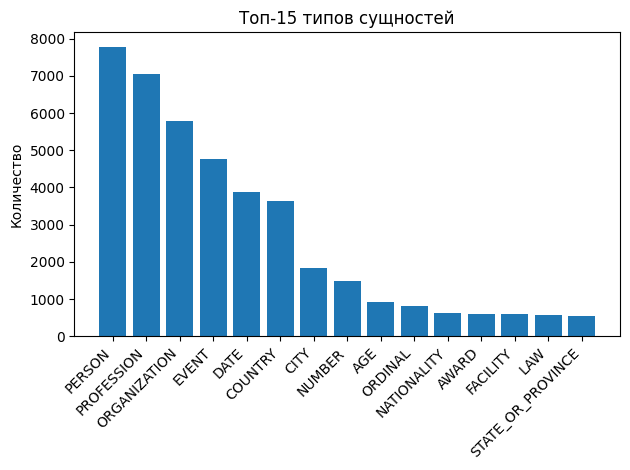

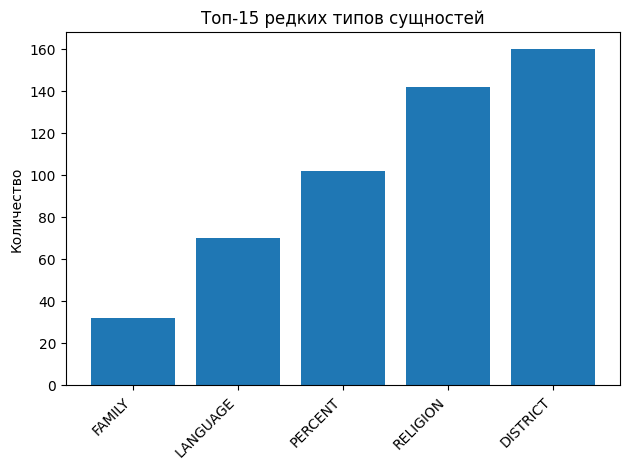

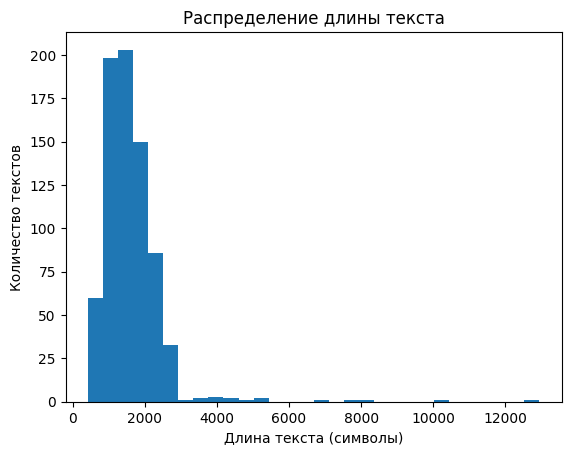

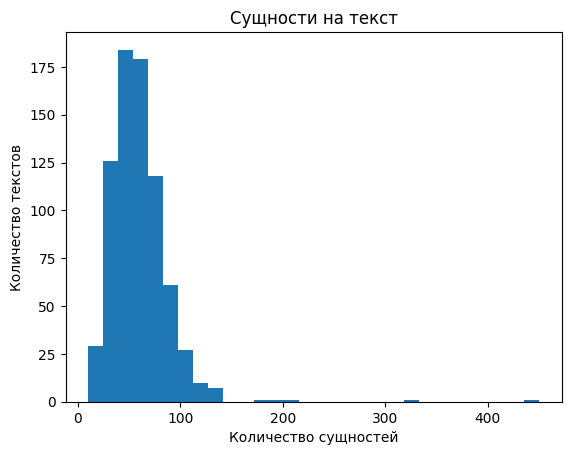

In [3]:
import json
from collections import Counter
import matplotlib.pyplot as plt

texts_lengths = []
entities_per_doc = []
entity_type_counter = Counter()

with open('./data/train.jsonl', 'r', encoding="utf-8") as f:
    for line in f:
        doc = json.loads(line)
        texts_lengths.append(len(doc["text"]))
        entities = doc.get("entities", [])
        entities_per_doc.append(len(entities))
        for ent in entities:
            parts = ent.split("\t")[1].split()
            ent_type = parts[0]
            entity_type_counter[ent_type] += 1

top15 = entity_type_counter.most_common(15)
labels, values = zip(*top15)

# Топ-15 типов сущностей
plt.figure()
plt.bar(labels, values)
plt.xticks(rotation=45, ha="right")
plt.title("Топ-15 типов сущностей")
plt.ylabel("Количество")
plt.tight_layout()
plt.show()

# Топ-5 редких типов сущностей
rare_5 = entity_type_counter.most_common()[::-1][:5]
labels, values = zip(*rare_5)
plt.figure()
plt.bar(labels, values)
plt.xticks(rotation=45, ha="right")
plt.title("Топ-15 редких типов сущностей")
plt.ylabel("Количество")
plt.tight_layout()
plt.show()

# Распределение длины текстов
plt.figure()
plt.hist(texts_lengths, bins=30)
plt.title("Распределение длины текста")
plt.xlabel("Длина текста (символы)")
plt.ylabel("Количество текстов")
plt.show()

# Число сущностей на текст
plt.figure()
plt.hist(entities_per_doc, bins=30)
plt.title("Сущности на текст")
plt.xlabel("Количество сущностей")
plt.ylabel("Количество текстов")
plt.show()

##### Вывод:
- Есть длинные тексты, стоит обрезать часть датасета по длине текста для уменьшения шума.
- Есть тексты с большим количество сущностей, возможно стоит отбросить их для уменьшения шума.

##### Парсинг и подготовка таргетов

Ниже - две заранее подготовленные функции парсинга строкового формата NEREL. Их вы получаете и можете использовать сразу (не меняйте имена).

Ожидаемые дополнительные функции, которые вы должны реализовать:

- `build_examples_from_nerel(records: List[dict], event_list: List[str]) -> List[dict]` - для каждого документа вернуть словарь с полями: `text`, `tokens` (word-tokenization по пробелам), `token_spans` (символьные оффсеты слов), `tags` (BIO per token), `cls_vec` (multihot длиной len(event_list)).

- `make_event_list(records, K=30)` - собрать топ-K типов событий/relations и вернуть список.



**Правила BIO и сопоставления:**

- Токенизация для BIO - простая `text.split()` (по пробелам). Офсеты токенов вычисляются на основе поиска токена в тексте (учтите повторы; используйте скользящий указатель).
- Для каждой сущности (start, end - символьные оффсеты) пометьте токены, которые пересекаются с интервалом сущности.
- Метки: `B-TYPE`, `I-TYPE`, `O`.



In [4]:

import re


# Функции парсинга строкового формата NEREL
def parse_entity_line(line: str):
    parts = line.split('\t')
    if len(parts) < 3:
        return None
    ent_id = parts[0].strip()
    type_pos = parts[1].strip()
    text = parts[2].strip() if len(parts) > 2 else ''
    m = re.match(r'(\S+)\s+(\d+)\s+(\d+)', type_pos)
    if not m:
        return None
    ent_type = m.group(1)
    start = int(m.group(2))
    end = int(m.group(3))
    return {'id': ent_id, 'type': ent_type, 'start': start, 'end': end, 'text': text}

def parse_relation_line(line: str):
    parts = line.split('\t')
    if len(parts) < 2:
        return None
    rel_id = parts[0].strip()
    body = parts[1].strip()
    m = re.match(r'(\S+)\s+Arg1:(\S+)\s+Arg2:(\S+)', body)
    if not m:
        return None
    rel_type = m.group(1)
    arg1 = m.group(2); arg2 = m.group(3)
    return {'id': rel_id, 'type': rel_type, 'arg1': arg1, 'arg2': arg2}



In [5]:
with open('./data/train.jsonl', 'r', encoding="utf-8") as f:
    for line in f:
        doc = json.loads(line)
        print(parse_entity_line(doc['entities'][0]))
        print(parse_relation_line(doc['relations'][0]))
        break


{'id': 'T1', 'type': 'NATIONALITY', 'start': 62, 'end': 74, 'text': 'американцами'}
{'id': 'R1', 'type': 'TAKES_PLACE_IN', 'arg1': 'T70', 'arg2': 'T12'}


In [6]:
from collections import Counter

def make_event_list(records, K=30):
    """
    Собирает топ-K типов relations (событий)
    """
    counter = Counter()
    for doc in records:
        for rel_line in doc.get('relations', []):
            rel = parse_relation_line(rel_line)
            if rel is not None:
                counter[rel['type']] += 1
    return [event for event, _ in counter.most_common(K)]

def build_examples_from_nerel(records, event_list):
    examples = []

    for doc in records:
        text = doc['text']

        # Отсекаем длинные тексты
        if len(text) > 3000:
            continue

        # Парсинг сущностей
        entities = []
        for ent_line in doc.get('entities', []):
            ent = parse_entity_line(ent_line)
            if ent is not None:
                entities.append(ent)

        # Отсекаем документы с большим количеством сущностей
        if len(entities) > 150:
            continue

        # Токенизация
        tokens = text.split()

        # Символьные оффсеты токенов
        token_spans = []
        cursor = 0
        for tok in tokens:
            start = text.find(tok, cursor)
            end = start + len(tok)
            token_spans.append((start, end))
            cursor = end

        # BIO теги 
        tags = ['O'] * len(tokens)

        for ent in entities:
            ent_start = ent['start']
            ent_end = ent['end']
            ent_type = ent['type']

            first = True
            for i, (tok_start, tok_end) in enumerate(token_spans):
                # проверка пересечения
                if tok_end > ent_start and tok_start < ent_end:
                    if first:
                        tags[i] = f'B-{ent_type}'
                        first = False
                    else:
                        tags[i] = f'I-{ent_type}'

        # Multihot cls_vec
        cls_vec = [0] * len(event_list)
        rel_types = set()

        for rel_line in doc.get('relations', []):
            rel = parse_relation_line(rel_line)
            if rel is not None:
                rel_types.add(rel['type'])

        for i, ev in enumerate(event_list):
            if ev in rel_types:
                cls_vec[i] = 1

        examples.append({
            'text': text,
            'tokens': tokens,
            'token_spans': token_spans,
            'tags': tags,
            'cls_vec': cls_vec
        })

    return examples


In [7]:
import json


with open('./data/train.jsonl', 'r', encoding="utf-8") as f:
    docs = [json.loads(line) for line in f]
    event_list = make_event_list(docs)
    examples_from_nerel = build_examples_from_nerel(docs, event_list)
    print(event_list)
    print(examples_from_nerel[0])
    

['WORKPLACE', 'ALTERNATIVE_NAME', 'WORKS_AS', 'PARTICIPANT_IN', 'POINT_IN_TIME', 'TAKES_PLACE_IN', 'HEADQUARTERED_IN', 'ORIGINS_FROM', 'LOCATED_IN', 'AGENT', 'AGE_IS', 'HAS_CAUSE', 'PRODUCES', 'AWARDED_WITH', 'PART_OF', 'IDEOLOGY_OF', 'MEMBER_OF', 'CONVICTED_OF', 'INANIMATE_INVOLVED', 'SUBEVENT_OF', 'SUBORDINATE_OF', 'KNOWS', 'MEDICAL_CONDITION', 'PARENT_OF', 'PLACE_RESIDES_IN', 'OWNER_OF', 'ABBREVIATION', 'FOUNDED_BY', 'ORGANIZES', 'PENALIZED_AS']
{'text': 'Российские менеджеры отказались возглавлять "газовую ОПЕК"\nПравительство России не смогло найти кандидатуру генерального секретаря Форума стран - экспортеров газа (ФСЭГ), который в прессе часто называют "газовой ОПЕК". Об этом пишет газета "Коммерсант". По ее данным, все потенциальные претенденты от России отказались от предлагаемой им должности, поэтому Россия поехала на саммит ФСЭГ в Дохе без своего кандидата.\n\n"Коммерсант" отмечает, что генеральным секретарем организации должен был стать россиянин: об этом, по сведениям источ

##### 3. Токенизация и выравнивание меток

Задачи:

- Выбрать `AutoTokenizer(..., use_fast=True)`.
- Реализовать `tokenize_and_align_labels(examples, tokenizer, label2id, max_length)`:
  - Токенизировать текст (return_offsets_mapping
  - Преобразовать word-level BIO метки в token-level метки (subword → label = -100 / ignore_index, для первых субтокенов ставится соответствующий тег `B-`/`I-`)
  - Вернуть словарь с `input_ids`, `attention_mask`, `labels` (token-level), `cls_labels`

- Собрать `torch.utils.data.Dataset` и `DataLoader`. Можно использовать `DataCollatorForTokenClassification` либо сделать кастомный collator, который возвращает батчи с `cls_labels`.



In [8]:
import torch


class Config:
    # Модели
    MODEL_NAME = "xlm-roberta-base"

    # Гиперпараметры
    BATCH_SIZE = 1
    EPOCHS = 20
    DROPOUT = 0.1
    LR = 3e-5
    SEED = 42

    DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    print(f"DEVICE: {DEVICE}")

    # Путь сохранения лучшей модели
    SAVE_PATH = "best_model.pth"


config = Config()

DEVICE: cuda:0


In [9]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    config.MODEL_NAME,
    use_fast=True
)

/home/user/Projects/Bert/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# все BIO-метки
unique_labels = sorted(
    {tag for ex in examples_from_nerel for tag in ex["tags"]}
)

label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for label, i in label2id.items()}

def tokenize_and_align_labels(examples, tokenizer, label2id, max_length=512):
    tokenized_inputs = tokenizer(
        [ex["tokens"] for ex in examples],
        is_split_into_words=True,
        return_offsets_mapping=True,
        padding=True,
        truncation=True,
        max_length=max_length
    )

    all_labels = []
    all_cls_labels = []

    for i, ex in enumerate(examples):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        word_labels = ex["tags"]

        labels = []
        prev_word_id = None

        for word_id in word_ids:
            if word_id is None:
                labels.append(-100)
            elif word_id != prev_word_id:
                labels.append(label2id[word_labels[word_id]])
            else:
                # сабтокены игнорируем
                labels.append(-100)

            prev_word_id = word_id

        all_labels.append(labels)
        all_cls_labels.append(ex["cls_vec"])

    tokenized_inputs.pop("offset_mapping")

    tokenized_inputs["labels"] = all_labels
    tokenized_inputs["cls_labels"] = all_cls_labels

    return tokenized_inputs

In [11]:
import torch
from torch.utils.data import Dataset


class NerelDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
        # token-level NER labels
        self.num_ner_labels = len(label2id)
        # document-level CLS labels
        # multi-label => размер вектора
        first_cls = encodings["cls_labels"][0]
        self.num_cls_labels = len(first_cls)

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.encodings["input_ids"][idx]),
            "attention_mask": torch.tensor(self.encodings["attention_mask"][idx]),
            "labels": torch.tensor(self.encodings["labels"][idx]),
            "cls_labels": torch.tensor(self.encodings["cls_labels"][idx], dtype=torch.float)
        }

In [12]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, random_split


class NerelCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, batch):
        input_ids = pad_sequence(
            [x["input_ids"] for x in batch],
            batch_first=True,
            padding_value=self.tokenizer.pad_token_id
        )
        attention_mask = pad_sequence(
            [x["attention_mask"] for x in batch],
            batch_first=True,
            padding_value=0
        )
        labels = pad_sequence(
            [x["labels"] for x in batch],
            batch_first=True,
            padding_value=-100
        )
        cls_labels = torch.stack([x["cls_labels"] for x in batch])

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
            "cls_labels": cls_labels
        }

encodings = tokenize_and_align_labels(
    examples_from_nerel,
    tokenizer,
    label2id,
    max_length=512
)

full_dataset = NerelDataset(encodings)
generator = torch.Generator().manual_seed(config.SEED)
train_dataset, val_dataset = random_split(
    full_dataset, 
    [0.8, 0.2],
    generator=generator,
)

collator = NerelCollator(tokenizer)

train_loader = DataLoader(
    train_dataset,
    config.BATCH_SIZE,
    shuffle=True,
    collate_fn=collator
)
valid_loader = DataLoader(
    val_dataset,
    config.BATCH_SIZE,
    shuffle=True,
    collate_fn=collator
)

first_batch = next(iter(train_loader))
# Проверяем размерности
for key, value in first_batch.items():
    print(f"{key}: shape = {value.shape}, dtype = {value.dtype}")


# Проверка -100 для subword-токенов
# Обычно -100 ≈ 30–60% токенов (CLS, SEP, padding, subwords)
labels = first_batch["labels"]

# количество ignore_index
num_ignored = (labels == -100).sum()
num_total = labels.numel()

print(f"Ignored tokens: {num_ignored}/{num_total}")

input_ids: shape = torch.Size([1, 512]), dtype = torch.int64
attention_mask: shape = torch.Size([1, 512]), dtype = torch.int64
labels: shape = torch.Size([1, 512]), dtype = torch.int64
cls_labels: shape = torch.Size([1, 30]), dtype = torch.float32
Ignored tokens: 234/512


In [13]:
# Визуальная проверка alignment
tokens = tokenizer.convert_ids_to_tokens(first_batch["input_ids"][0])
labels = first_batch["labels"][0]

count = 0
for tok, lab in zip(tokens, labels):
    if lab.item() == -100:
        print(f"{tok:15s} -> IGNORE")
    else:
        print(f"{tok:15s} -> {id2label[lab.item()]}")
    count += 1    
    if count >= 50:
        break

<s>             -> IGNORE
▁С              -> O
мена            -> IGNORE
▁портрет        -> O
ов              -> IGNORE
▁на             -> O
▁доллар         -> B-MONEY
ах              -> IGNORE
▁Гар            -> B-PERSON
ри              -> IGNORE
ет              -> IGNORE
▁Та             -> I-PERSON
б               -> IGNORE
мен             -> IGNORE
▁Куп            -> O
ю               -> IGNORE
ра              -> IGNORE
▁в              -> O
▁20             -> B-MONEY
▁долларов       -> I-MONEY
▁США            -> B-COUNTRY
▁2004           -> B-DATE
▁года           -> I-DATE
▁100            -> B-MONEY
▁долларов       -> I-MONEY
▁К              -> I-MONEY
ША              -> IGNORE
▁с              -> O
▁изображение    -> O
м               -> IGNORE
▁не             -> O
г               -> IGNORE
ров             -> IGNORE
-               -> IGNORE
раб             -> IGNORE
ов              -> IGNORE
▁на             -> O
▁план           -> O
та              -> IGNORE
ции             -> IGNO

##### 4. Модель: `JointModel` + custom loss (uncertainty weighting)


In [14]:
import torch
import torch.nn as nn
from transformers import AutoModel

class JointModel(nn.Module):
    def __init__(
        self,
        encoder_name: str,
        num_ner_labels: int,
        num_cls_labels: int,
        dropout_prob: float = 0.1,
        use_uncertainty_weight: bool = True
    ):
        super().__init__()

        self.encoder = AutoModel.from_pretrained(encoder_name)
        hidden_size = self.encoder.config.hidden_size
        self.dropout = nn.Dropout(dropout_prob)
        self.token_classifier = nn.Linear(hidden_size, num_ner_labels)
        self.cls_classifier = nn.Linear(hidden_size, num_cls_labels)

        self.token_loss_fct = nn.CrossEntropyLoss(ignore_index=-100)
        self.cls_loss_fct = nn.BCEWithLogitsLoss()

        self.use_uncertainty_weight = use_uncertainty_weight

        if self.use_uncertainty_weight:
            self.log_sigma_token = nn.Parameter(torch.tensor(0.0))
            self.log_sigma_cls = nn.Parameter(torch.tensor(0.0))

    def forward(
        self,
        input_ids,
        attention_mask,
        labels=None,        
        cls_labels=None     
    ):
        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )

        sequence_output = outputs.last_hidden_state          
        pooled_output = outputs.last_hidden_state[:, 0]      

        sequence_output = self.dropout(sequence_output)
        pooled_output = self.dropout(pooled_output)

        token_logits = self.token_classifier(sequence_output) 
        cls_logits = self.cls_classifier(pooled_output)        

        loss = None
        token_loss = None
        cls_loss = None

        if labels is not None and cls_labels is not None:
            token_loss = self.token_loss_fct(
                token_logits.view(-1, token_logits.size(-1)),
                labels.view(-1)
            )
            cls_loss = self.cls_loss_fct(cls_logits, cls_labels)

            if self.use_uncertainty_weight:
                loss_token_term = (
                    torch.exp(-2.0 * self.log_sigma_token) * token_loss
                    + self.log_sigma_token
                )
                loss_cls_term = (
                    torch.exp(-2.0 * self.log_sigma_cls) * cls_loss
                    + self.log_sigma_cls
                )
                loss = loss_token_term + loss_cls_term
            else:
                loss = token_loss + cls_loss

        return {
            "loss": loss,
            "token_loss": token_loss,
            "cls_loss": cls_loss,
            "token_logits": token_logits,
            "cls_logits": cls_logits
        }
    

model = JointModel(
    config.MODEL_NAME, 
    full_dataset.num_ner_labels,
    full_dataset.num_cls_labels,
    dropout_prob=config.DROPOUT,
    )
model.to(config.DEVICE)

JointModel(
  (encoder): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

##### 5. Training / Validation



In [15]:
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
from tqdm import tqdm
import numpy as np


def build_optimizer_and_scheduler(model, dataloader, num_epochs, lr=3e-5, weight_decay=0.01):
    """Создание optimizer и scheduler"""
    optimizer = AdamW(
        model.parameters(),
        lr=lr,
        weight_decay=weight_decay
    )

    num_training_steps = len(dataloader) * num_epochs
    num_warmup_steps = int(0.1 * num_training_steps)

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=num_training_steps
    )

    return optimizer, scheduler


def train_epoch(model, dataloader, optimizer, scheduler, device):
    """Обучение одной эпохи"""
    model.train()
    total_loss = 0.0

    for batch in tqdm(dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs["loss"]

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [16]:
from seqeval.metrics import f1_score as ner_f1_score
from sklearn.metrics import f1_score as cls_f1_score, precision_score, recall_score


def evaluate_ner(model, dataloader, id2label, device):
    """Подсчет метрик для NER"""
    model.eval()

    true_labels, pred_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)

            logits = outputs["token_logits"]
            preds = torch.argmax(logits, dim=-1)

            for i in range(preds.size(0)):
                pred_seq, true_seq = [], []
                for p, t in zip(preds[i], batch["labels"][i]):
                    if t.item() == -100:
                        continue
                    pred_seq.append(id2label[p.item()])
                    true_seq.append(id2label[t.item()])

                pred_labels.append(pred_seq)
                true_labels.append(true_seq)

    return ner_f1_score(true_labels, pred_labels)


def evaluate_cls(model, dataloader, device, threshold=0.5):
    """Подсчет метрик для CLS"""
    model.eval()

    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)

            probs = torch.sigmoid(outputs["cls_logits"])
            preds = (probs > threshold).int()

            y_true.append(batch["cls_labels"].cpu().numpy())
            y_pred.append(preds.cpu().numpy())

    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)

    return {
        "micro_f1": cls_f1_score(y_true, y_pred, average="micro"),
        "precision": precision_score(y_true, y_pred, average="micro"),
        "recall": recall_score(y_true, y_pred, average="micro")
    }

In [17]:
def train_model(
    model,
    train_loader,
    valid_loader,
    num_epochs,
    optimizer,
    scheduler,
    device,
    id2label,
    save_path
):
    """Основный цикл обучения"""
    best_score = -1.0
    logs = []

    for epoch in range(1, num_epochs + 1):
        train_loss = train_epoch(
            model, train_loader, optimizer, scheduler, device
        )

        ner_f1 = evaluate_ner(model, valid_loader, id2label, device)
        cls_metrics = evaluate_cls(model, valid_loader, device)

        score = ner_f1 + cls_metrics["micro_f1"]

        logs.append({
            "epoch": epoch,
            "train_loss": train_loss,
            "ner_f1": ner_f1,
            "cls_micro_f1": cls_metrics["micro_f1"]
        })

        print(
            f"Epoch {epoch}: "
            f"loss={train_loss:.4f}, "
            f"NER F1={ner_f1:.4f}, "
            f"CLS micro-F1={cls_metrics['micro_f1']:.4f}"
        )

        if hasattr(model, "log_sigma_token"):
            print(
                f"  log_sigma_token={model.log_sigma_token.item():.3f}, "
                f"log_sigma_cls={model.log_sigma_cls.item():.3f}"
            )
        
        if score > best_score:
            best_score = score
            torch.save({
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "epoch": epoch,
                "ner_f1": ner_f1,
                "cls_micro_f1": cls_metrics["micro_f1"]
            }, save_path)

            print(f"✅ Model saved (best score = {best_score:.4f})")

    return logs

##### Запуск процесса обучения:

In [18]:
optimizer, scheduler = build_optimizer_and_scheduler(
    model=model,
    dataloader=train_loader,
    num_epochs=config.EPOCHS,
    lr=config.LR, 
    weight_decay=0.01,
)

logs = train_model(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    num_epochs=config.EPOCHS,
    optimizer=optimizer,
    scheduler=scheduler,
    device=config.DEVICE,
    id2label=id2label,
    save_path=config.SAVE_PATH,
)
print(logs)

100%|██████████| 584/584 [01:34<00:00,  6.15it/s]


Epoch 1: loss=2.2368, NER F1=0.5890, CLS micro-F1=0.7278
  log_sigma_token=0.002, log_sigma_cls=0.001
✅ Model saved (best score = 1.3168)


100%|██████████| 584/584 [01:37<00:00,  6.01it/s]


Epoch 2: loss=1.0270, NER F1=0.6968, CLS micro-F1=0.7399
  log_sigma_token=0.001, log_sigma_cls=-0.000
✅ Model saved (best score = 1.4367)


100%|██████████| 584/584 [01:36<00:00,  6.02it/s]


Epoch 3: loss=0.7992, NER F1=0.7213, CLS micro-F1=0.7583
  log_sigma_token=-0.006, log_sigma_cls=-0.008
✅ Model saved (best score = 1.4796)


100%|██████████| 584/584 [01:37<00:00,  6.02it/s]


Epoch 4: loss=0.6438, NER F1=0.7355, CLS micro-F1=0.7733
  log_sigma_token=-0.018, log_sigma_cls=-0.020
✅ Model saved (best score = 1.5087)


100%|██████████| 584/584 [01:33<00:00,  6.22it/s]


Epoch 5: loss=0.5354, NER F1=0.7457, CLS micro-F1=0.7849
  log_sigma_token=-0.032, log_sigma_cls=-0.033
✅ Model saved (best score = 1.5305)


100%|██████████| 584/584 [01:37<00:00,  6.00it/s]


Epoch 6: loss=0.4421, NER F1=0.7487, CLS micro-F1=0.7832
  log_sigma_token=-0.046, log_sigma_cls=-0.045
✅ Model saved (best score = 1.5320)


100%|██████████| 584/584 [01:37<00:00,  5.99it/s]


Epoch 7: loss=0.3700, NER F1=0.7405, CLS micro-F1=0.7997
  log_sigma_token=-0.058, log_sigma_cls=-0.057
✅ Model saved (best score = 1.5401)


100%|██████████| 584/584 [01:36<00:00,  6.03it/s]


Epoch 8: loss=0.3065, NER F1=0.7535, CLS micro-F1=0.8071
  log_sigma_token=-0.071, log_sigma_cls=-0.068
✅ Model saved (best score = 1.5605)


100%|██████████| 584/584 [01:33<00:00,  6.22it/s]


Epoch 9: loss=0.2421, NER F1=0.7597, CLS micro-F1=0.8102
  log_sigma_token=-0.082, log_sigma_cls=-0.079
✅ Model saved (best score = 1.5699)


100%|██████████| 584/584 [01:33<00:00,  6.22it/s]


Epoch 10: loss=0.1860, NER F1=0.7537, CLS micro-F1=0.8138
  log_sigma_token=-0.092, log_sigma_cls=-0.088


100%|██████████| 584/584 [01:39<00:00,  5.89it/s]


Epoch 11: loss=0.1358, NER F1=0.7585, CLS micro-F1=0.8152
  log_sigma_token=-0.101, log_sigma_cls=-0.097
✅ Model saved (best score = 1.5737)


100%|██████████| 584/584 [01:37<00:00,  6.02it/s]


Epoch 12: loss=0.0906, NER F1=0.7615, CLS micro-F1=0.8172
  log_sigma_token=-0.109, log_sigma_cls=-0.105
✅ Model saved (best score = 1.5786)


100%|██████████| 584/584 [01:34<00:00,  6.21it/s]


Epoch 13: loss=0.0502, NER F1=0.7592, CLS micro-F1=0.8213
  log_sigma_token=-0.116, log_sigma_cls=-0.113
✅ Model saved (best score = 1.5805)


100%|██████████| 584/584 [01:36<00:00,  6.03it/s]


Epoch 14: loss=0.0144, NER F1=0.7573, CLS micro-F1=0.8239
  log_sigma_token=-0.123, log_sigma_cls=-0.119
✅ Model saved (best score = 1.5812)


100%|██████████| 584/584 [01:37<00:00,  6.02it/s]


Epoch 15: loss=-0.0202, NER F1=0.7586, CLS micro-F1=0.8201
  log_sigma_token=-0.128, log_sigma_cls=-0.124


100%|██████████| 584/584 [01:33<00:00,  6.22it/s]


Epoch 16: loss=-0.0463, NER F1=0.7594, CLS micro-F1=0.8203
  log_sigma_token=-0.132, log_sigma_cls=-0.129


100%|██████████| 584/584 [01:36<00:00,  6.03it/s]


Epoch 17: loss=-0.0686, NER F1=0.7580, CLS micro-F1=0.8213
  log_sigma_token=-0.136, log_sigma_cls=-0.132


100%|██████████| 584/584 [01:36<00:00,  6.03it/s]


Epoch 18: loss=-0.0889, NER F1=0.7586, CLS micro-F1=0.8239
  log_sigma_token=-0.138, log_sigma_cls=-0.135
✅ Model saved (best score = 1.5826)


100%|██████████| 584/584 [01:34<00:00,  6.19it/s]


Epoch 19: loss=-0.1013, NER F1=0.7602, CLS micro-F1=0.8273
  log_sigma_token=-0.140, log_sigma_cls=-0.136
✅ Model saved (best score = 1.5875)


100%|██████████| 584/584 [01:37<00:00,  6.01it/s]


Epoch 20: loss=-0.1099, NER F1=0.7613, CLS micro-F1=0.8267
  log_sigma_token=-0.140, log_sigma_cls=-0.137
✅ Model saved (best score = 1.5880)
[{'epoch': 1, 'train_loss': 2.2367961207685405, 'ner_f1': np.float64(0.5890374331550803), 'cls_micro_f1': 0.727810650887574}, {'epoch': 2, 'train_loss': 1.0270444617083627, 'ner_f1': np.float64(0.6968331968331969), 'cls_micro_f1': 0.7398878063182758}, {'epoch': 3, 'train_loss': 0.7991661720284043, 'ner_f1': np.float64(0.7213225828308152), 'cls_micro_f1': 0.7582938388625592}, {'epoch': 4, 'train_loss': 0.6437721986272563, 'ner_f1': np.float64(0.735462509484721), 'cls_micro_f1': 0.773286467486819}, {'epoch': 5, 'train_loss': 0.5353609824629679, 'ner_f1': np.float64(0.7456639378382128), 'cls_micro_f1': 0.7848854507587028}, {'epoch': 6, 'train_loss': 0.4421401181296535, 'ner_f1': np.float64(0.7487214927436074), 'cls_micro_f1': 0.7832454598711189}, {'epoch': 7, 'train_loss': 0.3699604320556742, 'ner_f1': np.float64(0.7404890399093877), 'cls_micro_f1':

##### 6. Инференс, квантизация и анализ ошибок

Проведите качественный анализ на 8–10 примерах: где NER ошибается? Какие типы сущностей плохо определяются? Насколько квантизация может ускорить инференс и сильно ли она ухудшает модель?


In [19]:
def load_best_model(model, path, device):
    checkpoint = torch.load(path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)
    model.eval()
    print(
        f"Loaded model from epoch {checkpoint['epoch']}, "
        f"NER F1={checkpoint['ner_f1']:.4f}"
    )
    return model

In [20]:
from collections import defaultdict
import random


def ner_error_analysis(
    model,
    dataloader,
    tokenizer,
    id2label,
    device,
    max_examples=10,
    seed=42
):
    """
    Выводит примеры с ошибками NER и статистику по типам сущностей
    """
    random.seed(seed)

    model.eval()
    examples_with_errors = []
    error_stats = defaultdict(int)

    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)

            logits = outputs["token_logits"]
            preds = torch.argmax(logits, dim=-1)

            for i in range(preds.size(0)):
                input_ids = batch["input_ids"][i]
                tokens = tokenizer.convert_ids_to_tokens(
                    input_ids.cpu().tolist()
                )

                gold_labels = batch["labels"][i]
                pred_labels = preds[i]

                sent_tokens = []
                gold_tags = []
                pred_tags = []
                errors = []

                for tok, g, p in zip(tokens, gold_labels, pred_labels):
                    if g.item() == -100:
                        continue

                    gold_tag = id2label[g.item()]
                    pred_tag = id2label[p.item()]

                    sent_tokens.append(tok)
                    gold_tags.append(gold_tag)
                    pred_tags.append(pred_tag)

                    if gold_tag != pred_tag:
                        errors.append((tok, gold_tag, pred_tag))

                        # считаем ошибки по типу сущности
                        gold_type = gold_tag.split("-")[-1] if "-" in gold_tag else gold_tag
                        error_stats[gold_type] += 1

                if errors:
                    examples_with_errors.append({
                        "tokens": sent_tokens,
                        "gold": gold_tags,
                        "pred": pred_tags,
                        "errors": errors
                    })

    # случайно выберем max_examples примеров
    sampled = random.sample(
        examples_with_errors,
        min(max_examples, len(examples_with_errors))
    )

    for idx, ex in enumerate(sampled, 1):
        print(f"Пример {idx}")
        print("Токены:")
        print(" ".join(ex["tokens"]))
        print("Эталонные:")
        print(" ".join(ex["gold"]))
        print("Предсказанные:")
        print(" ".join(ex["pred"]))
        print()
        print("Ошибки:")
        for tok, g, p in ex["errors"]:
            print(f"{tok:15s}  BEST={g:10s} → PRED={p}")
        print('-' * 80)
    print("Статистика ошибок по типам сущностей")

    for ent, cnt in sorted(error_stats.items(), key=lambda x: -x[1]):
        print(f"{ent:10s}: {cnt}")
    
    return sampled, error_stats


In [21]:
import time

config.DEVICE = 'cpu'

model = load_best_model(
    model,
    config.SAVE_PATH,
    config.DEVICE
)

with open('./data/test.jsonl', 'r', encoding="utf-8") as f:
    docs = [json.loads(line) for line in f]
    event_list = make_event_list(docs)
    examples_from_nerel = build_examples_from_nerel(docs, event_list)

encodings = tokenize_and_align_labels(
    examples_from_nerel,
    tokenizer,
    label2id,
    max_length=512
)

test_dataset = NerelDataset(encodings)

test_loader = DataLoader(
    test_dataset,
    config.BATCH_SIZE,
    shuffle=True,
    collate_fn=collator
)

start = time.perf_counter()
examples, error_stats = ner_error_analysis(
    model=model,
    dataloader=test_loader,
    tokenizer=tokenizer,
    id2label=id2label,
    device=config.DEVICE,
    max_examples=10
)
print("-" * 80)
print(f"Общее время инференса: {round(time.perf_counter() - start, 2)} c.")


Loaded model from epoch 20, NER F1=0.7613
Пример 1
Токены:
▁США ▁арест ▁китай ▁за ▁ ▁шпион ▁Не ▁завод ▁Hum ▁принадлеж ▁компании ▁Phillip ▁66 ▁Министерство ▁ ▁США ▁сообщил ▁что ▁20 ▁декабря ▁2018 ▁года ▁арест ▁гражданин ▁Китая ▁которого ▁обвиня ▁в ▁ ▁шпион ▁Америка ▁ ▁компания ▁Phillip ▁66 ▁в ▁которой ▁ ▁35 ▁Хо ▁Тан ▁( ▁Tan ▁оценива ▁на ▁им ▁ущерб ▁в ▁1 ▁млрд ▁долларов ▁По ▁данным ▁обвинения ▁Тан ▁скача ▁сот ▁файл ▁каса ▁разработки ▁« ▁продукта ▁которые ▁он ▁намер ▁использовать ▁в ▁интерес ▁китай ▁компании ▁которая ▁предложил ▁ему ▁работу ▁На ▁странице ▁Та ▁в ▁LinkedIn ▁говорится ▁что ▁он ▁работает ▁в ▁Phillip ▁66 ▁в ▁Бар ▁штат ▁Ок ▁с ▁мая ▁2017 ▁года ▁Его ▁опыт ▁опис ▁как ▁« ▁материалов ▁и ▁систем ▁для ▁хранения ▁воз ▁энергии ▁Тан ▁отвечал ▁в ▁компании ▁за ▁исследования ▁и ▁раз ▁технологий ▁ли ▁аккумулятор ▁Ра ▁он ▁более ▁11 ▁лет ▁ ▁в ▁ ▁технолог ▁институт ▁в ▁качестве ▁при ▁у ▁и ▁а ▁исследований ▁По ▁данным ▁Ф ▁компания ▁обрати ▁в ▁ведомство ▁на ▁прошло ▁не ▁со ▁о ▁кра ▁ком ▁секрет ▁а

Динамическая квантизация:

In [22]:
import time
import torch
import torch.nn as nn

model.eval()
model.cpu()

quantized_model = torch.quantization.quantize_dynamic(
    model,
    {nn.Linear},
    dtype=torch.qint8
)

start = time.perf_counter()
examples, error_stats = ner_error_analysis(
    model=quantized_model,
    dataloader=test_loader,
    tokenizer=tokenizer,
    id2label=id2label,
    device=config.DEVICE,
    max_examples=10
)
print("-" * 80)
print(f"Общее время инференса: {round(time.perf_counter() - start, 2)} c.")


/tmp/ipykernel_14083/2269971544.py:8: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  quantized_model = torch.quantization.quantize_dynamic(


Пример 1
Токены:
▁Как ▁Виктор ▁Аль ▁пос ▁с ▁Иван ▁Ф ▁Виктор ▁Аль ▁Кул ▁14 ▁ноября ▁2018 ▁года ▁в ▁квартир ▁преподава ▁Ли ▁Виктор ▁Аль ▁Кул ▁произ ▁конфликт ▁хозяин ▁квартиры ▁с ▁гост ▁поэт ▁Иван ▁Ф ▁Ж ▁после ▁чего ▁Иван ▁Ф ▁был ▁го ▁с ▁но ▁ран ▁в ▁одну ▁из ▁бо ▁Москвы ▁При ▁в ▁квартиру ▁полицейски ▁на ▁за ▁Виктор ▁Аль ▁в ▁на ▁и ▁до ▁в ▁отделение ▁полиции ▁где ▁Виктор ▁Аль ▁был ▁доп ▁и ▁дал ▁показания ▁что ▁прича ▁к ▁ранен ▁Иван ▁Ф ▁но ▁удар ▁нож ▁не ▁на ▁— ▁потер ▁по ▁себя ▁сам ▁После ▁того ▁как ▁Виктор ▁Аль ▁Кул ▁от ▁на ▁своей ▁страни ▁в ▁Facebook ▁Виктор ▁Аль ▁о ▁пост ▁где ▁рассказал ▁следующее ▁По ▁данным ▁« ▁поэт ▁Иван ▁Ф ▁Ж ▁го ▁в ▁20- ▁гор ▁В ▁ГК ▁им ▁А ▁Ер ▁где ▁поэт ▁был ▁про ▁рассказал ▁что ▁Иван ▁Ф ▁Ж ▁получил ▁коло ▁ран ▁яго ▁между ▁тем ▁ТА ▁утверждает ▁что ▁у ▁поэт ▁ран ▁живота ▁Сам ▁поэт ▁Иван ▁Ф ▁Ж ▁рассказал ▁о ▁конфликт ▁с ▁критик ▁Виктор ▁Аль ▁Кул ▁в ▁результате ▁которого ▁он ▁получил ▁травм ▁что ▁пере ▁пере ▁в ▁по ▁произ ▁в ▁квартир ▁критика ▁в ▁Юр ▁проезд ▁столицы ▁г

##### Заключение

1. Проведя анализ EDA были приняты следующие корректировки датасета:
- Есть длинные тексты, стоит обрезать часть датасета по длине текста для уменьшения шума.
- Есть тексты с большим количество сущностей, возможно стоит отбросить их для уменьшения шума.
2. На 20 эпохе обучения модель достигла метрик NER F1=0.7613, CLS micro-F1=0.8267, что соответствует требованиям token_f1 ≥ 0.5 и cls_micro_f1 ≥ 0.8 на подвыборке.
3. На 10 тестовых примерах выполнена оценка, где NER ошибается и как влияет CLS. Показана статистика ошибок по типам сущностей.
4. Выполнено сравнения исходной моделе и квантованой. В соответсвии с логами понятно, что скорость инференса увеличилась в 2 раза (с 23.06 c. до 9.94 c.) на 10 тестовых данных. Качество упало, но незначительно (можно посмотреть по выводам статистиик ошибок по типам сущностей)

 